<a href="https://colab.research.google.com/github/alexjercan/normals-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 228kB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 952kB 37.2MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!git clone https://github.com/alexjercan/normals-estimation.git
%cd normals-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [2]:
# Download pretrained model
torch.hub.download_url_to_file('https://github.com/alexjercan/normals-estimation/releases/download/v1.0/normal.pth', 'normal.pth')

In [3]:
# Download dataset stereo
!bash ./get_bdataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3961      0 --:--:-- --:--:-- --:--:--  3961
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1262M    0 1262M    0     0  78.6M      0 --:--:--  0:00:16 --:--:-- 81.8M
Completed in 41 seconds


In [4]:
!git pull
!python dataset.py
!python model.py

Already up to date.
dataset ok
model ok


In [11]:
import os
import re
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_stereo"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [{"imageL": "data/left.png", "imageR": "data/right.png", "output": "data/output.exr"}]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 1e-4
BETAS = [.9, .999]
EPS = 0.00000001
WEIGHT_DECAY = 0.0001

MILESTONES = [50, 100, 200]
GAMMA = 0.2

NUM_EPOCHS = 300
OUT_PATH = "./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [12]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
            M.MyIAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

detect_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)


In [13]:
model = Model()
model.apply(init_weights)
solver = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=LEARNING_RATE, betas=BETAS, 
                          eps=EPS, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [14]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TRAIN_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()


  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 50, loss=(total:6.0338 l1:0.14519360661506653 1-cos:5.888592720031738)
======NORMALS=======
MSE=1.7935	RMSE=1.3382	MAE=1.2245	MME=1.5699
TANGLE11.25=0.0616	TANGLE22.5=0.1491	TANGLE30.0=0.1953



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 51, loss=(total:6.9712 l1:0.08931058645248413 1-cos:6.881912708282471)
======NORMALS=======
MSE=1.7971	RMSE=1.3396	MAE=1.2254	MME=1.5700
TANGLE11.25=0.0630	TANGLE22.5=0.1497	TANGLE30.0=0.1952



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 52, loss=(total:4.7935 l1:0.17069274187088013 1-cos:4.622811317443848)
======NORMALS=======
MSE=1.7811	RMSE=1.3336	MAE=1.2188	MME=1.5676
TANGLE11.25=0.0641	TANGLE22.5=0.1514	TANGLE30.0=0.1977



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 53, loss=(total:6.8476 l1:0.11418324708938599 1-cos:6.733408451080322)
======NORMALS=======
MSE=1.7803	RMSE=1.3334	MAE=1.2183	MME=1.5696
TANGLE11.25=0.0636	TANGLE22.5=0.1528	TANGLE30.0=0.1992



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 54, loss=(total:7.3339 l1:0.10073836147785187 1-cos:7.2331719398498535)
======NORMALS=======
MSE=1.7884	RMSE=1.3363	MAE=1.2210	MME=1.5693
TANGLE11.25=0.0638	TANGLE22.5=0.1513	TANGLE30.0=0.1976



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 55, loss=(total:7.0160 l1:0.11424778401851654 1-cos:6.90172004699707)
======NORMALS=======
MSE=1.7725	RMSE=1.3303	MAE=1.2135	MME=1.5641
TANGLE11.25=0.0678	TANGLE22.5=0.1571	TANGLE30.0=0.2032



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 56, loss=(total:5.9861 l1:0.14684514701366425 1-cos:5.839303970336914)
======NORMALS=======
MSE=1.7873	RMSE=1.3360	MAE=1.2205	MME=1.5684
TANGLE11.25=0.0666	TANGLE22.5=0.1541	TANGLE30.0=0.1992



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 57, loss=(total:8.1885 l1:0.058686912059783936 1-cos:8.12982177734375)
======NORMALS=======
MSE=1.7960	RMSE=1.3392	MAE=1.2249	MME=1.5695
TANGLE11.25=0.0640	TANGLE22.5=0.1500	TANGLE30.0=0.1953



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 58, loss=(total:7.6814 l1:0.0807144045829773 1-cos:7.600724697113037)
======NORMALS=======
MSE=1.7744	RMSE=1.3311	MAE=1.2136	MME=1.5693
TANGLE11.25=0.0685	TANGLE22.5=0.1578	TANGLE30.0=0.2041



100%|██████████| 306/306 [02:47<00:00,  1.82it/s, epoch=59, loss=(total:3.6979 l1:0.23127388954162598 1-cos:3.466615676879883)]

eval_avg_error
Epoch: 59, loss=(total:3.6979 l1:0.23127388954162598 1-cos:3.466615676879883)
======NORMALS=======
MSE=1.7867	RMSE=1.3354	MAE=1.2182	MME=1.5674
TANGLE11.25=0.0686	TANGLE22.5=0.1568	TANGLE30.0=0.2023



In [15]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 153/153 [00:24<00:00,  6.17it/s]

eval_avg_error
Epoch: 59, loss=(total:6.2316 l1:0.13717497885227203 1-cos:6.094423770904541)
======NORMALS=======
MSE=1.8938	RMSE=1.3739	MAE=1.2777	MME=1.5708
TANGLE11.25=0.0530	TANGLE22.5=0.1300	TANGLE30.0=0.1697



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


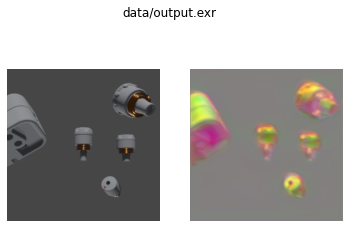

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


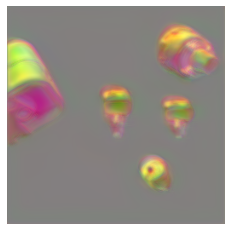

In [16]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, path in generatePredictions(model, images):
    plot_predictions([img], predictions, [path])
    save_predictions(predictions, [path])

In [17]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)